# Heart Disease Prediction – Modeling Phase

In this section, multiple classification models are trained and evaluated.

Evaluation includes:
- 5-fold Cross-Validation (ROC-AUC)
- Test-set performance metrics
- Confusion matrices
- ROC curve comparison

Since this is a medical classification task, recall and ROC-AUC are emphasized over accuracy alone.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [7]:
# Load cleaned dataset
df = pd.read_csv('../data/heart_cleaned.csv')

X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Load saved scaler from EDA
scaler = joblib.load('../models/scaler.pkl')
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print("Training size:", X_train.shape)
print("Testing size:", X_test.shape)

Training size: (734, 11)
Testing size: (184, 11)


## Cross-Validation Evaluation

5-fold cross-validation is performed on the training data to assess model robustness.

ROC-AUC is used as the scoring metric, as it is more appropriate for medical classification tasks than accuracy alone.

In [8]:
log_model = LogisticRegression(max_iter=1000, random_state=42)

# Cross-validation
log_cv = cross_val_score(log_model, X_train, y_train, cv=5, scoring='roc_auc')
print("Logistic Regression CV AUC:", log_cv.mean())
print("Std Dev:", log_cv.std())

# Train
log_model.fit(X_train, y_train)

# Test predictions
y_pred_log = log_model.predict(X_test)
y_prob_log = log_model.predict_proba(X_test)[:,1]

print("\n=== Logistic Regression Test Performance ===")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_log))
print(classification_report(y_test, y_pred_log))

Logistic Regression CV AUC: 0.9074253759890617
Std Dev: 0.03733018034828276

=== Logistic Regression Test Performance ===
Accuracy: 0.8478260869565217
ROC-AUC: 0.8988522238163557
              precision    recall  f1-score   support

           0       0.85      0.80      0.82        82
           1       0.85      0.88      0.87       102

    accuracy                           0.85       184
   macro avg       0.85      0.84      0.85       184
weighted avg       0.85      0.85      0.85       184



In [9]:
rf_model = RandomForestClassifier(random_state=42)

rf_cv = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='roc_auc')
print("Random Forest CV AUC:", rf_cv.mean())
print("Std Dev:", rf_cv.std())

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:,1]

print("\n=== Random Forest Test Performance ===")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))
print(classification_report(y_test, y_pred_rf))

Random Forest CV AUC: 0.9232685271167655
Std Dev: 0.02618003012351181

=== Random Forest Test Performance ===
Accuracy: 0.8695652173913043
ROC-AUC: 0.924079387852702
              precision    recall  f1-score   support

           0       0.85      0.85      0.85        82
           1       0.88      0.88      0.88       102

    accuracy                           0.87       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.87      0.87      0.87       184



### Clinical Interpretation of Random Forest Results

In medical diagnosis, minimizing false negatives is critical, as missed heart disease cases can have severe consequences.

Random Forest achieves strong recall for the positive class, indicating that the model is effective at identifying patients with heart disease.

Therefore, beyond accuracy, recall and ROC-AUC confirm that Random Forest is a clinically reliable baseline model.

In [10]:
svm_model = SVC(probability=True, random_state=42)

svm_cv = cross_val_score(svm_model, X_train, y_train, cv=5, scoring='roc_auc')
print("SVM CV AUC:", svm_cv.mean())
print("Std Dev:", svm_cv.std())

svm_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_test)
y_prob_svm = svm_model.predict_proba(X_test)[:,1]

print("\n=== SVM Test Performance ===")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_svm))
print(classification_report(y_test, y_pred_svm))

SVM CV AUC: 0.912865125439651
Std Dev: 0.0354833804592524

=== SVM Test Performance ===
Accuracy: 0.8641304347826086
ROC-AUC: 0.9201339072214252
              precision    recall  f1-score   support

           0       0.89      0.79      0.84        82
           1       0.85      0.92      0.88       102

    accuracy                           0.86       184
   macro avg       0.87      0.86      0.86       184
weighted avg       0.87      0.86      0.86       184



## ROC Curve Comparison

ROC curves allow visual comparison of model discrimination ability.

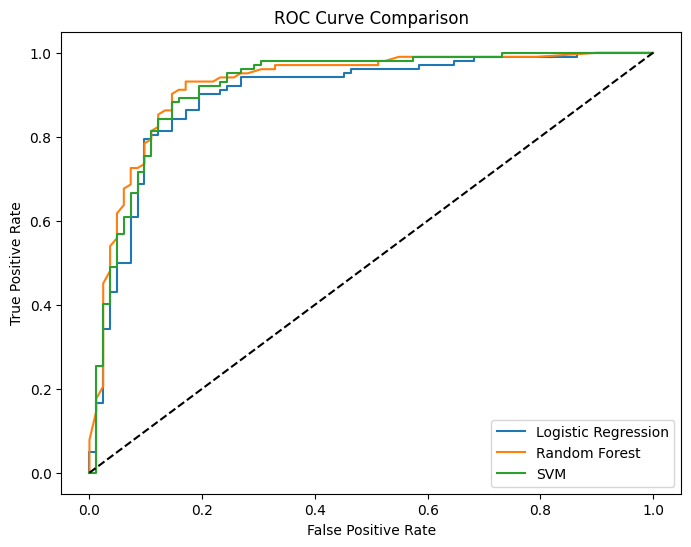

In [11]:
plt.figure(figsize=(8,6))

for model_name, y_prob in [
    ("Logistic Regression", y_prob_log),
    ("Random Forest", y_prob_rf),
    ("SVM", y_prob_svm)
]:
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=model_name)

plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

### ROC Curve Interpretation

Random Forest achieves the highest ROC-AUC, indicating superior discrimination ability.
All models perform significantly better than random guessing (diagonal line),
suggesting strong predictive capability.

Given the medical context, the higher true positive rate at lower false positive rates
is particularly important to minimize missed heart disease cases.

In [12]:
comparison = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "SVM"],
    "CV AUC": [log_cv.mean(), rf_cv.mean(), svm_cv.mean()],
    "Test Accuracy": [
        accuracy_score(y_test, y_pred_log),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_svm)
    ],
    "Test AUC": [
        roc_auc_score(y_test, y_prob_log),
        roc_auc_score(y_test, y_prob_rf),
        roc_auc_score(y_test, y_prob_svm)
    ]
})

comparison

,Model,CV AUC,Test Accuracy,Test AUC
0,Logistic Regression,0.907425,0.847826,0.898852
1,Random Forest,0.923269,0.869565,0.924079
2,SVM,0.912865,0.864130,0.920134


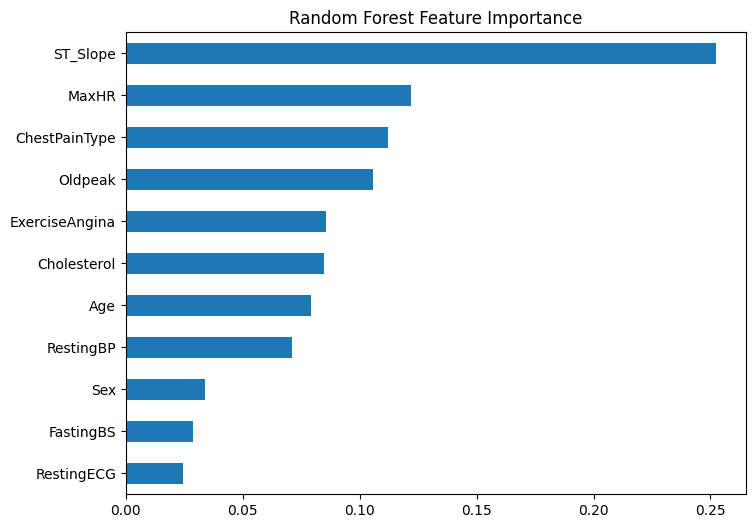

In [13]:
importances = pd.Series(rf_model.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh', figsize=(8,6))
plt.title("Random Forest Feature Importance")
plt.show()

# Modeling Summary

1. Cross-validation results show consistent performance across folds.
2. Random Forest achieves the highest ROC-AUC and accuracy.
3. Logistic Regression performs competitively, indicating linear relationships exist.
4. SVM performs moderately but does not outperform Random Forest.
   This suggests that the feature space may not require complex nonlinear decision boundaries beyond what ensemble methods like Random Forest can        capture.
6. Given the importance of recall in medical prediction, ROC-AUC and sensitivity were prioritized over accuracy.

Random Forest is selected as the best baseline model for hyperparameter tuning.

In [14]:
joblib.dump(log_model, '../models/logistic_regression.pkl')
joblib.dump(rf_model, '../models/random_forest.pkl')
joblib.dump(svm_model, '../models/svm.pkl')

print("All models saved successfully.")

All models saved successfully.
